In [1]:
import os
import sys
sys.path.append(os.getcwd())

from glob import glob
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog

from sklearn.metrics import classification_report, precision_score, recall_score, jaccard_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import multiprocessing
from joblib import Parallel, delayed
NUM_CORES = multiprocessing.cpu_count()

from metrics import *
from utils import *
from mask_proposal import *

In [2]:
#%% define path to images TRAIN

data = DataLoader('../../../data')
data.set_data('train')

  0%|▎                                                                                 | 1/294 [00:00<00:43,  6.76it/s]

Loading train data...


  0%|                                                                                           | 0/72 [00:00<?, ?it/s]

Loading test data...


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 15.85it/s]


In [3]:
#%% get features for training

features, labels = [],[]
def get_features_labels(image, mask):
    
    y_true = list(cv2.split(mask))
    y_pred = list(get_mask_proposal(image))
    mask_pred = (y_pred[0]|y_pred[1])/255.
    
    f,l = get_feats_labels(image, y_true[0]*mask_pred, 1)
    features.extend(f); labels.extend(l)
    f,l = get_feats_labels(image, y_true[1]*mask_pred, 2)
    features.extend(f); labels.extend(l)
    
    # background
    background = (y_pred[0]|y_pred[1]).astype('float') - (y_true[1]|y_true[0]).astype('float')
    background[background<0] = 0

    contour = cv2.findContours(background.astype('uint8'), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
    for cnt in contour:
        perimeter = cv2.arcLength(cnt,True)
        if perimeter<30:
            continue

        # remove noise
        draw = np.ones_like(background)
        cv2.drawContours(draw, [cnt], 0, (0,0,0), -1)

        background = background * draw
    f,l = get_feats_labels(image, background.astype('uint8'), 0)
    features.extend(f); labels.extend(l)
    
with Parallel(n_jobs=NUM_CORES, prefer="threads") as parallel:
    _ = parallel(delayed(get_features_labels)(image, mask) \
                      for image, mask in tqdm(data, total=len(data)))
    
features = np.array(features)
labels = np.array(labels)

len(features)

100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [01:06<00:00,  4.45it/s]


In [4]:
#%%

# kf = StratifiedKFold(n_splits=5)

# for train_index, test_index in kf.split(features, labels):
#     X_train, X_test = features[train_index], features[test_index]
#     y_train, y_test = labels[train_index], labels[test_index]

#     clf = make_pipeline(StandardScaler(), SVC(C=30, gamma='auto', class_weight='balanced'))
#     clf.fit(X_train, y_train)

#     y_pred = clf.predict(X_test)

#     print(classification_report(y_test, y_pred))
    
#     del clf

In [5]:
#%% Train SVM model

clf = make_pipeline(StandardScaler(), SVC(C=1, kernel='rbf', gamma='auto',\
                                          class_weight='balanced'))
clf.fit(features, labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, class_weight='balanced', gamma='auto'))])

In [6]:
import pickle

with open('clf.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
def post_process(ery_mask, spi_mask):
    
    kernel = np.ones((5,5),np.uint8)
    ery_mask = cv2.dilate(ery_mask, kernel, iterations=2)
    
    # fill ery masks
    contour = cv2.findContours(ery_mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
    for cnt in contour:
        _ = cv2.drawContours(ery_mask, [cnt], -1, (255,255,255), -1)
    
    ery_mask = cv2.erode(ery_mask, kernel, iterations=2)
    
    spi_mask[ery_mask==255] = 0
    
    return ery_mask, spi_mask

In [8]:
#%% evaluate on metrics

# define path to images TEST
data.set_data('test')

all_true, all_pred = [],[]

def make_predicts(image, mask):
    
    mask_true = list(cv2.split(mask))
    mask_pred = list(predict_masks(image, clf))
    
    mask_pred = post_process(*mask_pred)
    
    y_true = np.where(mask_true[0]==255, 1, 0)
    y_true = np.where(mask_true[1]==255, 2, y_true)
    
    y_pred = np.where(mask_pred[0]==255, 1, 0)
    y_pred = np.where(mask_pred[1]==255, 2, y_pred)
    
    all_true.append(y_true)
    all_pred.append(y_pred)
    
with Parallel(n_jobs=NUM_CORES, prefer="threads") as parallel:
    _ = parallel(delayed(make_predicts)(image, mask) \
                      for image, mask in tqdm(data, total=len(data)))

y_true = np.array(all_true).reshape(-1,1)
y_pred = np.array(all_pred).reshape(-1,1)

print(classification_report(y_true, y_pred))
print('Jaccard (macro avg): ', jaccard_score(y_true, y_pred, average='macro'))
print('Jaccard (weighted avg): ', jaccard_score(y_true, y_pred, average='weighted'))

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:11<00:00,  6.17it/s]


              precision    recall  f1-score   support

           0       0.98      0.93      0.96   3866076
           1       0.70      0.91      0.79    669416
           2       0.43      0.21      0.28     36796

    accuracy                           0.92   4572288
   macro avg       0.70      0.68      0.67   4572288
weighted avg       0.93      0.92      0.93   4572288

Jaccard (macro avg):  0.5761312917747058
Jaccard (weighted avg):  0.8716176258968269


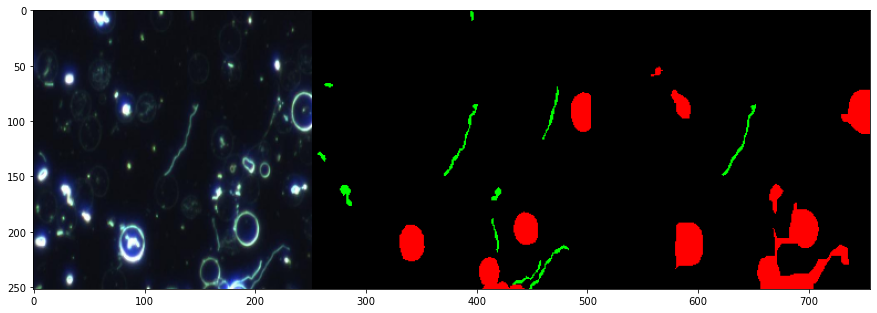

In [27]:
i = np.random.randint(0, len(data))
image, mask = data[i]

#%%
mask_true = list(cv2.split(mask))

mask_pred = list(predict_masks(image, clf))
mask_pred = post_process(*mask_pred)

ery_true = np.where(mask_true[0]==255, 255, 0)
spi_true = np.where(mask_true[1]==255, 255, 0)
y_true = cv2.merge([ery_true, spi_true, np.zeros_like(ery_true)])

ery_pred = np.where(mask_pred[0]==255, 255, 0)
spi_pred = np.where(mask_pred[1]==255, 255, 0)
y_pred = cv2.merge([ery_pred, spi_pred, np.zeros_like(ery_pred)])

plt.figure(figsize=(15,10))
plt.imshow(np.hstack([image, y_true, y_pred]))